# Makemore 3 - Exercises

Notes on the exercises from the [makemore #3 video](https://www.youtube.com/watch?v=P6sfmUTpUmc).<br>
The video description holds the exercises, which are also listed below.<br>
Feel free to try solving on your own first using [this starter notebook](./N004%20-%20Makemore_3_Exercises.ipynb).

1. Watch the [makemore #3 video](https://www.youtube.com/watch?v=P6sfmUTpUmc) on YouTube
2. Come back and complete the exercises to level up :)

In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

## Exercise 1 - Dead or Alive?

**Objective:** We did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that:
1. the network trains just fine or
2. the network doesn't train at all,
3. the network trains but only partially, and achieves a pretty bad final performance.

Inspect the gradients and activations to figure out what is happening and why the network (spoiler) is only partially training, and what part is being trained exactly (and why).

Let's set up the training environment first:

In [63]:
words = open('../names.txt', 'r').read().splitlines() # read in all the words
print(words[:5])           # Show the first eight words
print(len(words), 'words') # Total amount of words in our dataset

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033 words


In [64]:
# Build a vocabulary of characters map them to integers (these will be the index tokens)
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates
stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)
vocab_size = len(itos)

In [65]:
# Build the dataset
block_size = 3 # Context length: We look at this many characters to predict the next one

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)
  return X, Y

# Randomize the dataset (with reproducibility)
random.seed(42)
random.shuffle(words)

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


For the model, we will modify the `Linear` class constructor, replacing the `torch.randn` call with the `torch.zeros` equivalent.<br>
We won't change anything else about the logic itself. This way, we can most clearly trace the impact of zero-ed initial weights and biases.

In [66]:
# Linear Layer Definition (mimicing torch.nn.Linear's structure)
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    #self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.weight = torch.zeros(fan_in, fan_out)
    self.bias = torch.zeros(fan_out) if bias else None # Biases are optional here

  def __call__(self, x):
    self.out = x @ self.weight # W*x
    if self.bias is not None:  # Add biases if so desired
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) # return layer's tensors

In [67]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps            # Epsilon set to PyTorch default, you may change it
    self.momentum = momentum  # Momemtum set to PyTorch default, you may change it
    self.training = True
    # Initialize Parameters (trained with backprop)
    # (bngain -> gamma, bnbias -> beta)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Initialize Buffers
    # (Trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)


  def __call__(self, x):
    # Forward-Pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar = x.var(0, keepdim=True)   # Batch variance
    else:
      xmean = self.running_mean # Using the running mean as basis
      xvar = self.running_var   # Using the running variance as basis

    # Normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias

    # Update the running buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out


  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

In [68]:
# Similar to torch.tanh(), but Class-structure to make later steps easier
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [69]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].gamma *= 0.1 # As last layer is a Batch-Normalization
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'Params: {sum(p.nelement() for p in parameters)}') # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

47551


In [70]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = [] # Keeping track of loss
ud = []    # Keeping track of Update-to-Data ratio

for i in range(max_steps):
  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Tracking the stats
  if i % 10000 == 0: # Print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2958
  10000/ 200000: 2.7882
  20000/ 200000: 2.7518
  30000/ 200000: 2.8506
  40000/ 200000: 2.8221
  50000/ 200000: 2.8987
  60000/ 200000: 2.6038
  70000/ 200000: 2.6751
  80000/ 200000: 3.0131
  90000/ 200000: 2.7753
 100000/ 200000: 2.6079
 110000/ 200000: 2.5273
 120000/ 200000: 2.6690
 130000/ 200000: 2.6426
 140000/ 200000: 2.8423
 150000/ 200000: 2.5484
 160000/ 200000: 2.9788
 170000/ 200000: 2.9535
 180000/ 200000: 2.8622
 190000/ 200000: 2.8513


This loss progression looks bad. The loss decreases from $3.2958$ at the start to approximately $2.5273$ at $110,000$ steps, but it then fluctuates in this region with no further improvement.

However, this loss progression (be it a bad one) indicates some learning is happening. A completely non-functioning network would not show any improvement in loss.

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


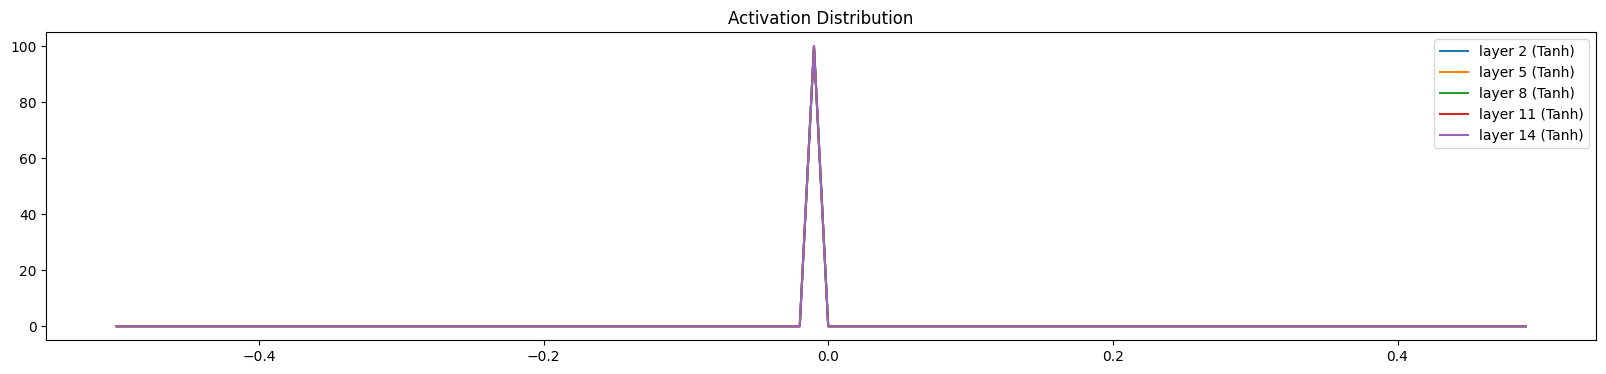

In [71]:
# Visualize histograms (forward pass activations) for the Tanh layers
# This is the ideal graph, very homogeneous
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

The activation distribution looks terrible, but we really called this upon ourselves. Here's why:

Every `Linear` layer computes its output as $output = W\cdot x + b$.<br>
Since $W=0$ and $b=0$ for each `Linear` layer, this output is always zero, which is also zero when activated with $\text{Tanh}$.

The `Linear` neurons are not getting activated at all, at any point, and cannot contribute meaningful information to the network's output formulation, but just 'scream' zero any time we want anything from them.

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


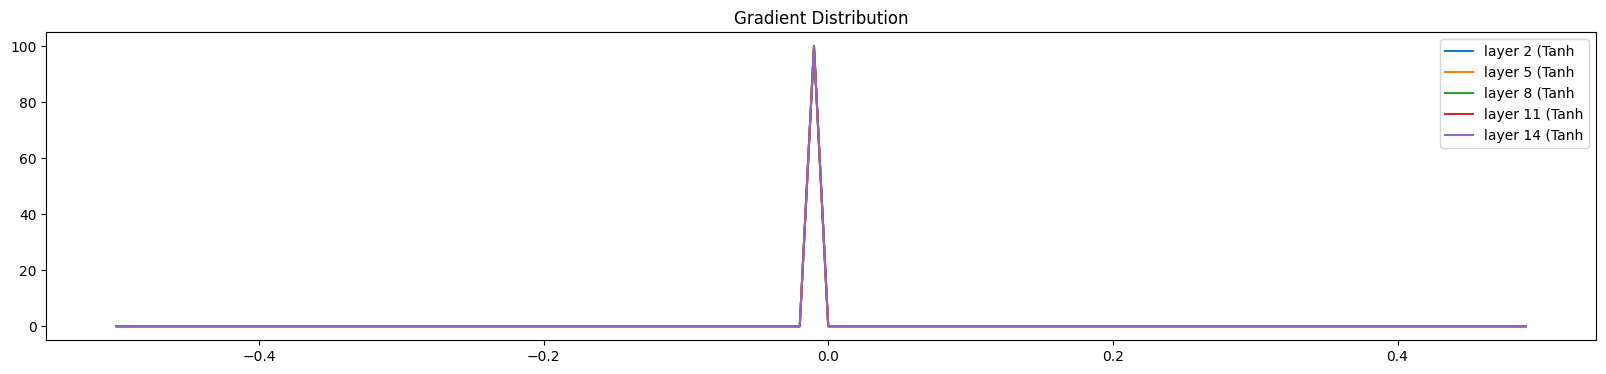

In [72]:
# Visualize Gradient Histogram (this graph looks good)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.title('Gradient Distribution')
plt.legend(legends);

Since the `Linear` neurons always produce a zero (activated) output, the gradients flowing through these layers will also be multiplied to death with this $0$. Our model as it is right now consists of mostly dead layers, those being all the `Linear` ones.

**But then why do we see some sort of decline in error during training?**

The embedding matrix `C` is likely the primary contributor to learning.
You may think that this can't be, because backprop would hit its head on all the zero-squashing `Linear` layers before even reaching and optimizing `C`.

But we have batch normalization.

More specifically, each `Linear` layer is directly followed by a `BatchNorm1d`, which itself introduces trainable parameters (`gamma` and `beta`).<br>
Therefore, even if the weights in `Linear` layers are dead/stagnant/zero, the `BatchNorm1d` parameters may train and adapt, providing some tiny learning capacity to the (overall few) parameters in `C`.

`BatchNorm1d` involuntarily helps some gradient information bypass the abyss that is each `Linear` layer. Therefore, training still indeed occurs in each `BatchNorm1d`'s `gramma` and `beta`, and because of that, a tiny amount of gradient information also propagates up to train `C`.

We can thus conclude that out of the three possible outcomes, we observe the third one:<br>
The network trains but only partially, and it achieves a pretty bad final performance.

## Exercise 2 - Folding BatchNorm

**Objective:** BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the BatchNorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time.<br>
- Set up a small $3$-layer MLP with BatchNorms,
- Train the network, then
- "fold" the BatchNorm gamma/beta into the preceeding `Linear` layer's $W,\ b$ by creating a new $W2,\ b2$ and erasing the BatchNorm.
- Verify that this gives the same forward pass during inference.

We will see that the BatchNorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

Going step by step, first, we should re-activate the `Linear` layer class from last exercise:

In [78]:
# Linear Layer Definition (mimicing torch.nn.Linear's structure)
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    #self.weight = torch.zeros(fan_in, fan_out)
    self.bias = torch.zeros(fan_out) if bias else None # Biases are optional here

  def __call__(self, x):
    self.out = x @ self.weight # W*x
    if self.bias is not None:  # Add biases if so desired
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) # return layer's tensors

The $3$-layer model can be cut out of the above model like so:

In [79]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].gamma *= 0.1 # As last layer is a Batch-Normalization
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'Params: {sum(p.nelement() for p in parameters)}') # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

Params: 16651


We apply the exact same training routine as before:

In [80]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = [] # Keeping track of loss
ud = []    # Keeping track of Update-to-Data ratio

for i in range(max_steps):
  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Tracking the stats
  if i % 10000 == 0: # Print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.3138
  10000/ 200000: 2.7694
  20000/ 200000: 2.2692
  30000/ 200000: 2.2127
  40000/ 200000: 2.2313
  50000/ 200000: 2.0179
  60000/ 200000: 1.7573
  70000/ 200000: 2.0154
  80000/ 200000: 2.2664
  90000/ 200000: 1.8668
 100000/ 200000: 1.9899
 110000/ 200000: 1.9657
 120000/ 200000: 2.3100
 130000/ 200000: 1.9577
 140000/ 200000: 1.8609
 150000/ 200000: 1.9832
 160000/ 200000: 2.2560
 170000/ 200000: 1.8296
 180000/ 200000: 2.3550
 190000/ 200000: 2.1229


**Now, what does it mean to fold the BatchNorm gamma/beta into the preceeding layer's weights and biases?**

As a reminder, this is how BatchNorm is formulated:<br>
![](./img/batch_norm_recipe.PNG)

$\gamma$ and $\beta$ are the trainable parameters of the `BatchNorm1d` layer.<br>
$\mu$ and $\sigma$ are the mean and standard deviation of the batch, respectively.<br>
They are the statistics that are used to normalize the batch.

The respectively preceeding linear layer is $y = W * x + b$.<br>
Now, folding effectively combines the `BatchNorm1d` layer into the `Linear` layer, so that the dedicated `BatchNorm1d` layer is no longer needed.

We can formulate such a folded layer as:<br>
$W_{\text{folded}} = W \cdot (\gamma / \sqrt{\sigma² + \epsilon})$, which approximates $W_{\text{folded}} = W \cdot (\gamma / \sigma)$<br>
$b_{\text{folded}} = (b - \mu) \cdot (\gamma / \sqrt{\sigma² + \epsilon}) + \beta$

A more detailed description would be (also refer to [forums.fast.ai](https://forums.fast.ai/t/faster-inference-batch-normalization-folding/69161)):

The linear layer $y = W * x + b$ is followed by the BatchNorm1d layer $BN(y) = \gamma \cdot \frac{y - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$.<br>
This succession is expressed as:<br>
$BN(Wx + b) = \gamma \cdot \frac{(Wx + b) - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$.<br>
Re-arranging these terms to match the shape of $y = W * x + b$ yields:<br>
$BN(Wx + b) = (\gamma \cdot \frac{W}{\sqrt{\sigma^2 + \epsilon}})x + (\gamma \cdot \frac{b - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta)$.<br><br>
And finally, moving the terms $W$ and $(b - \mu)$ outside the parentheses produces the terms from above:<br>
$$BN(Wx + b) = \underbrace{(W \cdot (\gamma / \sqrt{\sigma² + \epsilon}))}_{W_{\text{folded}}} * x + \underbrace{((b - \mu) \cdot (\gamma / \sqrt{\sigma² + \epsilon}) + \beta)}_{b_{\text{folded}}}$$

In [108]:
# Folding BatchNorm1d layers into their preceeding Linear layers
folded_layers = []
i = 0

while i < len(layers):
    if (isinstance(layers[i], Linear) and i + 1 < len(layers) and isinstance(layers[i + 1], BatchNorm1d)):
        # Retrieve the Linear and BatchNorm1d layers
        linear, bn = layers[i], layers[i + 1]
        
        # Turn off training mode for BatchNorm1d
        bn.training = False

        # Retrieve parameters, setup some space for the bias if not exists
        W = linear.weight
        b = linear.bias if linear.bias is not None else torch.zeros(linear.weight.shape[1])

        # Compute the scaling factor
        std = torch.sqrt(bn.running_var + bn.eps)
        scale = bn.gamma / std

        # Fold BatchNorm into Linear weights and biases
        # Won't name them W2, b2; That would just make things more confusing
        # W_folded and b_folded it is
        W_folded = W * scale.view(1, -1) # Broadcasting across input dim
        b_folded = (b - bn.running_mean) * scale + bn.beta

        # Build new folded parameter Linear layer
        folded_linear = Linear(W.shape[0], W.shape[1])
        with torch.no_grad():
            folded_linear.weight = torch.nn.Parameter(W_folded)
            folded_linear.bias = torch.nn.Parameter(b_folded)

        folded_layers.append(folded_linear)
        i += 2  # Skip this procedure for the BatchNorm layer
    else:
        # Transfer the layer as-is, it's non-foldable
        folded_layers.append(layers[i])
        i += 1

In [109]:
# Some random input
dummy_inp = torch.randn((batch_size, n_embd * block_size))

# Verify the folding correctness
with torch.no_grad():
    # Set BatchNorm1d layers to eval mode while forward passing
    x_unfolded = dummy_inp
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
        x_unfolded = layer(x_unfolded)

    # Forward pass through folded model
    # No need for eval mode, as we deleted BatchNorm1d
    x_folded = dummy_inp
    for layer in folded_layers:
        x_folded = layer(x_folded)

    if torch.allclose(x_unfolded, x_folded, atol=1e-5):
        print("Success! BatchNorm folding is correct.")
    else:
        print("Failure! Outputs mismatch within tolerance.")

Success! BatchNorm folding is correct.


<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>